<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_after_discussion_0324_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
import lightgbm as lgb
import os

import joblib

In [99]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [100]:
df = data.copy()

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [101]:
# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape


(7371, 15)

In [102]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")


總行數: 7371
含有unknown的行數: 0


In [ ]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


In [104]:
# 目標變數編碼

df[col] = df[col].map({"yes": 1, "no": 0})
# display(df["y"].value_counts())


In [105]:
# 二元特徵及目標變數編碼
ordinal_features = ["default", "housing", "loan"]

for col in ordinal_features:
  df[col] = df[col].map({"yes": 1, "no": 0})



In [106]:
# 提取特徵變數及目標變數

X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)


(7371, 14) (7371,)


In [107]:
# 切分訓練組、驗證組、測試組

# 切出測試集(保留最後評估用)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# 剩下的資料切成訓練、驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True, stratify=y_temp)
display(X_temp.shape, y_temp.shape)
display(X_test.shape, y_test.shape)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))
print(X_val.index.equals(y_val.index))


(5896, 14)

(5896,)

(1475, 14)

(1475,)

(4422, 14)

(4422,)

(1474, 14)

(1474,)

True
True
True


In [108]:
display(X_train.dtypes.value_counts())

,count
int64,9
object,5


In [109]:
# 欄位分類

int_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # 數值型欄位，做標準化縮放
ordinal_columns = ["education", "contact"] # 類別型欄位，做標籤編碼
binary_columns = ["default", "housing", "loan"] # ["yes", ""no] 二元欄位，前面已轉換，預處理不再做
ohe_columns = ['job', 'marital', 'poutcome'] # 類別型欄位，做ohe


all_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns
print(len(all_columns))
# all_columns


14


In [110]:
# 設置前處理器

categories_order = [
    ["primary", "secondary", "tertiary"],
    ['cellular', 'telephone']
]

preprocessor = ColumnTransformer(transformers=[
    ("int", StandardScaler(), int_columns),
    ("ordinal", OrdinalEncoder(categories=categories_order), ordinal_columns),
    ("passthrough", "passthrough", binary_columns),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_columns)
])


In [111]:
# 執行預處理

X_train_preproceed = preprocessor.fit_transform(X_train) # 訓練組預處理
X_val_preproceed = preprocessor.transform(X_val) # 驗證組預處理

# 儲存預處理器
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [112]:
# 整理欄位

ohe_columns = list(preprocessor.named_transformers_["ohe"].get_feature_names_out()) # 取得預處理器中的ohe欄位名稱
all_preprocessed_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns # 整合所有欄位名稱
len(all_preprocessed_columns)

X_train_preproceed = pd.DataFrame(X_train_preproceed, columns=all_preprocessed_columns, index=X_train.index) # 訓練組重新生成dataframe
X_val_preproceed = pd.DataFrame(X_val_preproceed, columns=all_preprocessed_columns, index=X_val.index) # 測試組重新生成dataframe

display(X_train_preproceed.shape, y_train.shape)
display(X_val_preproceed.shape, y_val.shape)

display(X_train_preproceed.head(3))
display(X_val_preproceed.head(3))


(4422, 28)

(4422,)

(1474, 28)

(1474,)

,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
35777,-0.245234,-0.435792,-0.737583,-0.678116,1.319633,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40885,0.541785,0.210741,-0.102427,-0.678116,-1.024494,-0.409674,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
37975,-1.207146,-0.441751,5.088918,-0.042948,1.194375,-0.409674,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
41264,-0.332680,-0.468864,-0.288739,-0.678116,-0.228206,-0.409674,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
43930,0.891571,-0.506702,-0.352255,1.227388,-1.069229,-0.223202,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34928,-0.595020,-0.260305,-0.026208,-0.678116,0.433875,0.149743,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [119]:
# 定義模型及設定超參數

model_def = {
    "random_forest": {
        "model": RandomForestClassifier(n_estimators=120, max_depth=15, min_samples_leaf=3, class_weight="balanced", random_state=42),
        "cache_path": "/content/rf_model.pkl"
    },
    "xgb": {
        "model": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
                    max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
                    subsample=1, reg_alpha=0.1, reg_lambda=100),
        "cache_path": "/content/xgb_model.pkl"
    },
    "logical_reg": {
        "model": LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
        "cache_path": "/content/lg_model.pkl"
    },
    "lgb": {
        "model": lgb.LGBMClassifier(random_state=42, num_leaves=4, max_depth=3, learning_rate=0.015, n_estimators=600, min_child_samples=15,
                      subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1, class_weight="balanced"), # boosting_type = 'gbdt'
        "cache_path": "/content/lgb.pkl"
    }
}



In [120]:
# 訓練模型

for name, data in model_def.items():
  path = data["cache_path"]
  if os.path.exists(path):
    print(f"model {name} 已存在")
  else:
    model = data["model"].fit(X_train_preproceed, y_train)
    joblib.dump(model, path)
    print(f"model {name} trained and saved")




model random_forest 已存在
model xgb 已存在
model logical_reg 已存在
[LightGBM] [Info] Number of positive: 1049, number of negative: 3373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 4422, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
model lgb trained and saved


In [121]:
# 對訓練組、驗證組進行預測，並取得 y_score (正類的機率分佈)存在字典 model_result

# 字典，存放訓練組、驗證組的正類分佈機率
model_result = {
    "train_result": {}, "val_result": {}
}

# 預測
for name, data in model_def.items():
  path = data["cache_path"]
  model = joblib.load(path)
  train_score = model.predict_proba(X_train_preproceed)[:, 1] # 對訓練組預測，取得正類的分佈機率
  val_score = model.predict_proba(X_val_preproceed)[:, 1] # 對驗證組預測，取得正類的分佈機率
  model_result["train_result"][name] = train_score
  model_result["val_result"][name] = val_score

for name, score in model_result.items():
  print(name, score)


train_result {'random_forest': array([0.00446491, 0.67608791, 0.35116166, ..., 0.38462289, 0.81151518,
       0.01258637]), 'xgb': array([0.01607142, 0.883325  , 0.5832508 , ..., 0.34264424, 0.92324257,
       0.01604787], dtype=float32), 'logical_reg': array([0.08776235, 0.883049  , 0.97724507, ..., 0.48818586, 0.98852462,
       0.064056  ]), 'lgb': array([0.02022181, 0.89537007, 0.612265  , ..., 0.47793657, 0.95638789,
       0.02022181])}
val_result {'random_forest': array([0.61923193, 0.68704864, 0.13897333, ..., 0.15270747, 0.17204917,
       0.05983841]), 'xgb': array([0.551936  , 0.599698  , 0.13687988, ..., 0.12290528, 0.15912612,
       0.06075998], dtype=float32), 'logical_reg': array([0.67192873, 0.518312  , 0.24267159, ..., 0.23495996, 0.20073938,
       0.15098404]), 'lgb': array([0.70217514, 0.79659894, 0.18772909, ..., 0.23038483, 0.15447077,
       0.07396493])}


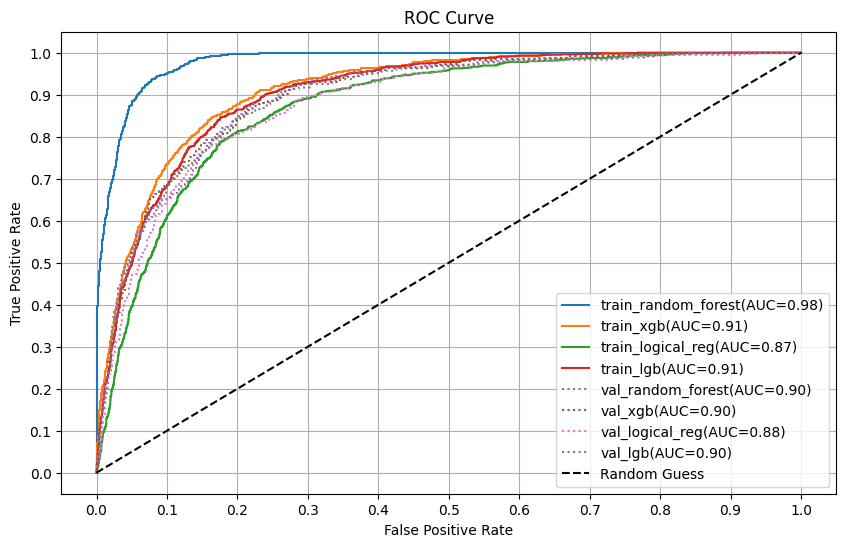

In [122]:
# 畫訓練組、驗證組的 ROC-AUC

plt.figure(figsize=(10, 6))

for k, v in model_result.items():
  for name, result in v.items():
    if k == "train_result": # 畫訓練組的 ROC curve
      fpr, tpr, _ = roc_curve(y_train, result)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f"train_{name}(AUC={roc_auc:.2f})")
    else: # 畫驗證組的 ROC curve
      fpr, tpr, _ = roc_curve(y_val, result)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, ":", label=f"val_{name}(AUC={roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("ROC Curve")
plt.legend()
plt.grid(True)




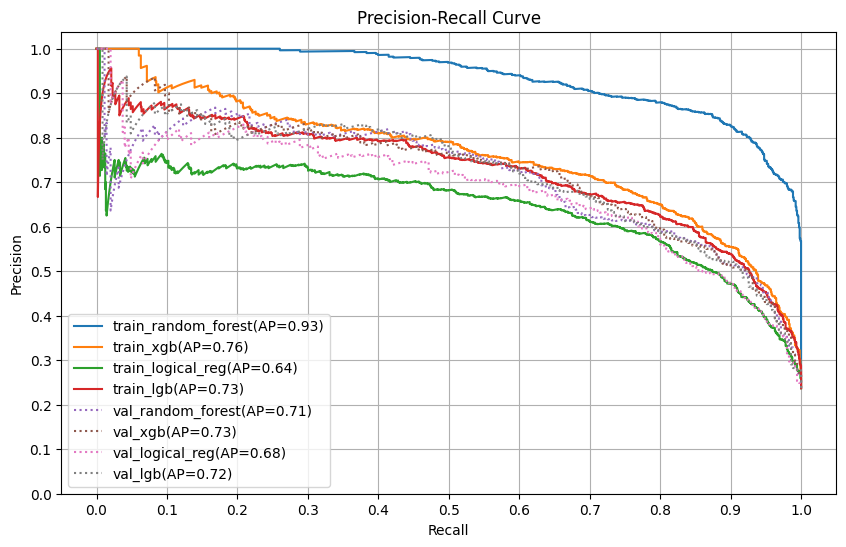

In [124]:
# 畫訓練組、驗證組的 PR-AUC

plt.figure(figsize=(10, 6))

for k, v in model_result.items():
  for name, result in v.items():
    if k == "train_result": # 畫訓練組的 PR curve
      precision, recall, _ = precision_recall_curve(y_train, result)
      ap_score = average_precision_score(y_train, result)
      plt.plot(recall, precision, label=f"train_{name}(AP={ap_score:.2f})")
    else: # 畫驗證組的 PR curve
      precision, recall, _ = precision_recall_curve(y_val, result)
      ap_score = average_precision_score(y_val, result)
      plt.plot(recall, precision, ":", label=f"val_{name}(AP={ap_score:.2f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xticks(ticks=np.arange(0, 1.1, 0.1))
plt.yticks(ticks=np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

# rfc 過擬合，xgb 最穩定, logical reg 訓練比驗證差




In [ ]:
# 找出 xgb 的 feature importance

model = joblib.load("/content/xgb_model.pkl")
feature_importance = model.feature_importances_
display(feature_importance.shape, len(X_train_preproceed.columns))

sorted_index = np.argsort(feature_importance)[::-1]
sorted_columns = np.array(X_train_preproceed.columns)[sorted_index]
sorted_importance = feature_importance[sorted_index]

feature_select = []
threshold = 0.01
for i, j in zip(sorted_columns, sorted_importance):
  if j >= threshold:
    print(f"{i}: {j}")
    feature_select.append(i)

print(feature_select)


# ['poutcome', 'housing', 'duration', 'job', 'marital', 'pdays', 'loan', 'education']


(28,)

28

poutcome_success: 0.2918546497821808
poutcome_failure: 0.18966537714004517
housing: 0.17693327367305756
duration: 0.10006710886955261
job_blue-collar: 0.04034768417477608
marital_single: 0.029562238603830338
pdays: 0.02684452384710312
loan: 0.021800510585308075
education: 0.019132690504193306
marital_married: 0.010547518730163574
['poutcome_success', 'poutcome_failure', 'housing', 'duration', 'job_blue-collar', 'marital_single', 'pdays', 'loan', 'education', 'marital_married']


In [ ]:
# 合併訓練組、驗證組

X_train_val_preproceed = pd.concat([X_train_preproceed, X_val_preproceed], axis=0)
y_train_val_preproceed = pd.concat([y_train, y_val], axis=0)

display(X_train_preproceed.shape, X_val_preproceed.shape)
display(X_train_val_preproceed.shape, y_train_val_preproceed.shape)




(4422, 28)

(1474, 28)

(5896, 28)

(5896,)

In [ ]:
# 合併後重新訓練，得到 final model

model_final = model_def["xgb"]["model"].fit(X_train_val_preproceed, y_train_val_preproceed)
joblib.dump(model_final, "model_final.pkl")


['model_final.pkl']

In [ ]:
# 對測試組進行預處理

X_test_preproceed = preprocessor.transform(X_test)
display(X_test.shape, y_test.shape)
display(X_test_preproceed.shape, y_test.shape)



(1475, 14)

(1475,)

(1475, 28)

(1475,)

test accuracy score: 0.8284745762711865
test classification report: 
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1125
           1       0.61      0.79      0.68       350

    accuracy                           0.83      1475
   macro avg       0.77      0.81      0.78      1475
weighted avg       0.85      0.83      0.84      1475



<Axes: >

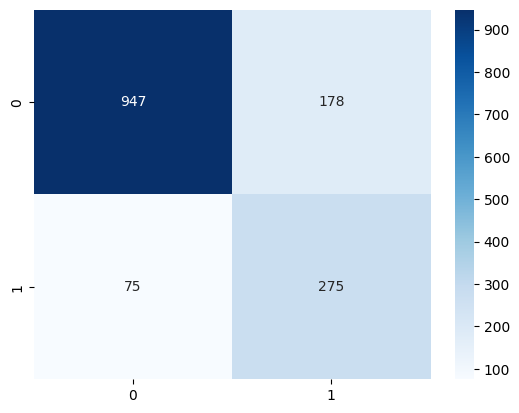

In [ ]:
# 對測試組進行預測

test_pred = model_final.predict(X_test_preproceed)

test_accuracy = accuracy_score(y_test, test_pred)
test_report = classification_report(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print(f"test accuracy score: {test_accuracy}")
print(f"test classification report: \n{test_report}")

sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")



In [ ]:


# 在預設門檻值0.5下，把每個模型的 accuracy, precision, recall, f1-score, tn, fn, tp, fp 抓出來
# def metrics(data, result):
#   precisions, recalls, thresholds = precision_recall_curve(data, result)
#   ap_score = average_precision_score(data, result)
#   f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
#   best_idx = np.argmax(f1s)
#   threshold = thresholds[best_idx]
#   y_pred = (result >= threshold).astype(int)
#   tn, fp, fn, tp = confusion_matrix(data, y_pred).ravel()
#   return precisions, recalls, ap_score

# 畫訓練組、驗證組的 PR-AUC

# plt.figure(figsize=(10, 6))
# for k, v in model_result.items():
#   for name, result in v.items():
#     if k == "train_result": # 畫訓練組的 PR curve
#       precisions, recalls, ap_score = metrics(y_train, result)
#       plt.plot(recalls, precisions, label=f"train_{name}(AP={ap_score:.2f})")
#     else: # 畫驗證組的 PR curve
#       precisions, recalls, ap_score = metrics(y_val, result)
#       plt.plot(recalls, precisions, ":",label=f"train_{name}(AP={ap_score:.2f})")


# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.xticks(ticks=np.arange(0, 1.1, 0.1))
# plt.yticks(ticks=np.arange(0, 1.1, 0.1))
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid(True)

# rfc 過擬合，xgb 最穩定, logical reg 訓練比驗證差


